# Small dataset text classification using deep learning

## 1. Recurrent (LSTM/GRU)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import os
import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('results.txt',sep="\n")
df

,ASTS
0,"print|index|and|values void,PredefinedType^Met..."
1,"printing|names void,PredefinedType^MethodDecla..."
2,"colorful|write|line void,PredefinedType^Method..."
3,"printing|names void,PredefinedType^MethodDecla..."
4,"sort|three|numbers int,PredefinedType^ArrayTyp..."
5,"addition int,PredefinedType^MethodDeclaration_..."
6,"area double,PredefinedType^MethodDeclaration_P..."
7,"area double,PredefinedType^MethodDeclaration_P..."
8,"area double,PredefinedType^MethodDeclaration_P..."
9,"print|names void,PredefinedType^MethodDeclarat..."


In [4]:
training_data = df[df.columns[0]].to_numpy()
training_data = np.reshape(training_data,(-1,1))
training_data[:1]

array([['print|index|and|values void,PredefinedType^MethodDeclaration_ParameterList_Parameter_IdentifierName,array void,PredefinedType^MethodDeclaration_ParameterList_Parameter,my|array void,PredefinedType^MethodDeclaration_Block_ForStatement_VariableDeclaration_VariableDeclarator_EqualsValueClause_InvocationExpression_SimpleMemberAccessExpression0_IdentifierName0,my|array void,PredefinedType^MethodDeclaration_Block_ForStatement_LessThanOrEqualExpression_InvocationExpression_SimpleMemberAccessExpression0_IdentifierName0,my|array void,PredefinedType^MethodDeclaration_Block_ForStatement_ExpressionStatement_InvocationExpression_ArgumentList1_Argument2_InvocationExpression_SimpleMemberAccessExpression0_IdentifierName0,my|array void,PredefinedType^MethodDeclaration_Block_ForStatement_VariableDeclaration_PredefinedType,int void,PredefinedType^MethodDeclaration_Block_ForStatement_VariableDeclaration_VariableDeclarator_EqualsValueClause_InvocationExpression_SimpleMemberAccessExpression0_Identi

In [5]:
vectorizer = layers.TextVectorization(output_mode="int")
vectorizer.adapt(training_data)
integer_data = vectorizer(training_data)
print(integer_data)

tf.Tensor(
[[2019 1105 1101 ...    0    0    0]
 [ 622   25   25 ...    0    0    0]
 [3049   19  544 ...    0    0    0]
 ...
 [3048   19   19 ...    0    0    0]
 [2318 1098 1104 ...    0    0    0]
 [3297  162  162 ...    0    0    0]], shape=(22, 3239), dtype=int64)


In [28]:
#****************************************
#need to modify this part
#labels = df[df.columns[0]]
#y = np.argmax(pd.get_dummies(labels).to_numpy(), axis=1)
X_train, X_test = train_test_split(training_data,  test_size=0.20, random_state=42)

In [35]:
max_features = 20000
embedding_dim = 30

inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorizer(inputs)
x = layers.Embedding(max_features + 1, embedding_dim)(x)

#x = layers.LSTM(10, dropout=0.2, recurrent_dropout=0.2)(x)
x = tf.keras.layers.GRU(10)(x)

x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.3)(x)
num_classes = 10
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, None, 30)          600030    
                                                                 
 gru_5 (GRU)                 (None, 10)                1260      
                                                                 
 dense_5 (Dense)             (None, 20)                220       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                           

In [36]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    keras.callbacks.TensorBoard(logdir)
]
history = model.fit(X_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/10


ValueError: in user code:

    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 891, in train_step
        self._validate_target_and_loss(y, loss)
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 848, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=sparse_categorical_crossentropy, and therefore expects target data to be provided in `fit()`.


In [8]:
%load_ext tensorboard
%tensorboard --logdir logs

In [9]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 31ms/step - loss: 2.1681 - acc: 0.5185


[2.168147087097168, 0.5185185074806213]

In [10]:
predictions = model.predict(X_test)
print(predictions.shape)

1/1 [==============================] - 0s 411ms/step
(27, 10)


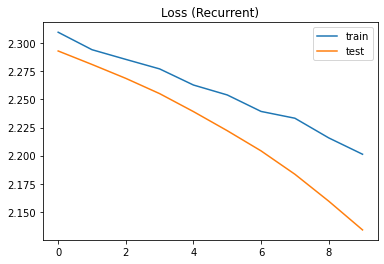

In [11]:
plt.title('Loss (Recurrent)')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 2. Transformers

In [37]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [38]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 30  # Only consider the first 200 words of each sentence

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model_tr = keras.Model(inputs=inputs, outputs=outputs)

model_tr.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_tr.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 token_and_position_embeddin  (None, 30, 32)           640960    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 30, 32)           10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_8 (Dropout)         (None, 32)                0   

In [39]:
vectorizer_tr = layers.TextVectorization(output_mode="int", output_sequence_length=maxlen)
vectorizer_tr.adapt(training_data)
X_train_tr = vectorizer_tr(X_train)
X_test_tr = vectorizer_tr(X_test)
X_train_tr

<tf.Tensor: shape=(17, 30), dtype=int64, numpy=
array([[3513,  143,  141,   41, 2401, 2487,  651,  651, 2396,  142,   40,
         140, 2399, 2486,  650,  650, 2395, 2484,  649,  649, 2391, 2473,
         646,  646, 2398,   96,   13,   13,  343,   97],
       [2318, 1098, 1104, 1159,   31, 2457, 2456,   13, 2386, 2389, 2388,
        2387,    4,    6,    5,    8,    9,    7,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [ 332,   19,   19,  163,  164,  311,  313,  545,  546,  552,  551,
          25,   25,  550,   74,  554,   31,  168,  139,   37,   37,  167,
         324,   75,   75,  315,  315,  316,  316,  319],
       [ 622,   19,   19,  163,  164, 1097, 1164,   25,   74,   31,  168,
         139,   37,   37, 1554, 1551,  568,  568,   14,   14,   21,   21,
          20,   20, 2895, 2907, 2903, 2905,  145,  202],
       [1690, 2571, 2463,  645,  645, 2504, 2627,  663,   87,   87,   87,
         654,  672,  663,   87,   87,   87,  654,  672, 26

In [42]:
history_tr = model_tr.fit(X_train_tr, y_train_tr, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\CodingEnv\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\CodingEnv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\CodingEnv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\CodingEnv\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\CodingEnv\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\CodingEnv\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\CodingEnv\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\CodingEnv\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\CodingEnv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\CodingEnv\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\CodingEnv\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\CodingEnv\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\CodingEnv\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\CodingEnv\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\CodingEnv\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\CodingEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\CodingEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\CodingEnv\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\CodingEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\CodingEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\CodingEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\YAHYA\AppData\Local\Temp/ipykernel_2828/2695498976.py", line 1, in <module>
      history_tr = model_tr.fit(X_train_tr, X_train_tr, epochs=10, batch_size=32, validation_split=0.2)
    File "C:\CodingEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\CodingEnv\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "C:\CodingEnv\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\CodingEnv\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\CodingEnv\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\CodingEnv\lib\site-packages\keras\losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\CodingEnv\lib\site-packages\keras\backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [13,10] and labels shape [390]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_8215]

In [130]:
model_tr.evaluate(X_test_tr, y_test_tr)

1/1 [==============================] - 0s 25ms/step - loss: 1.3369 - accuracy: 0.6296


[1.3368749618530273, 0.6296296119689941]

In [131]:
predictions_tr = model_tr.predict(X_test_tr)
print(predictions_tr.shape)

(27, 10)


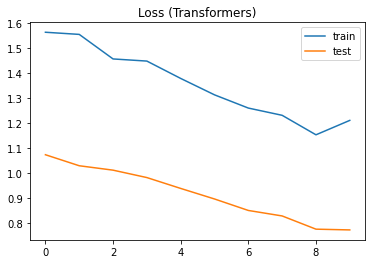

In [133]:
plt.title('Loss (Transformers)')
plt.plot(history_tr.history['loss'], label='train')
plt.plot(history_tr.history['val_loss'], label='test')
plt.legend()
plt.show()